In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Dataset
El dataset seleccionado corresponde al histórico del porcentaje mensual de la inflación en Colombia presentado por el banco de la república (disponible en su [base de datos](https://suameca.banrep.gov.co/buscador-de-series/#/)).

Primero vamos a cargar el dataset directamente desde el repositorio.

In [ ]:
!git clone https://github.com/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation
data = pd.read_excel('Laboratory-LSTM-GRU-Inflation/dataset/Datos-Inflacion.xlsx', decimal=',')
data.head()

Cloning into 'Laboratory-LSTM-GRU-Inflation'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 23.16 KiB | 4.63 MiB/s, done.


,Fecha,Inflacion
0,NaN,NaN
1,31/07/1955,-0.87
2,31/08/1955,-0.01
3,30/09/1955,0.84
4,31/10/1955,0.77


El conjunto de datos contiene el historial de inflación desde 1951. En primer lugar, recortaremos la información a partir de 1995, ya que los patrones observados en los registros más antiguos difieren de los de las últimas tres décadas. Posteriormente, prepararemos las columnas para estandarizar los tipos de datos.

In [ ]:
# Convertimos la columna 'Fecha' a objeto datetime y la seleccionamos como índice
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y', errors='coerce')
data = data.dropna(subset=['Fecha']).set_index('Fecha')

# Eliminamos filas sin datos en la columna 'Inflacion'
data = data.dropna(subset=['Inflacion']).copy()

# Dividimos los datos de la inflacion sobre 100 para tener el porcentaje
data['Inflacion'] = pd.to_numeric(data['Inflacion'], errors='coerce') / 100

# Filtramos los datos desde 2000
data = data[data.index >= '2000-01-01']
display(data.head())

,Inflacion
Fecha,
2000-01-31,0.0825
2000-02-29,0.0889
2000-03-31,0.0973
2000-04-30,0.0996
2000-05-31,0.1000


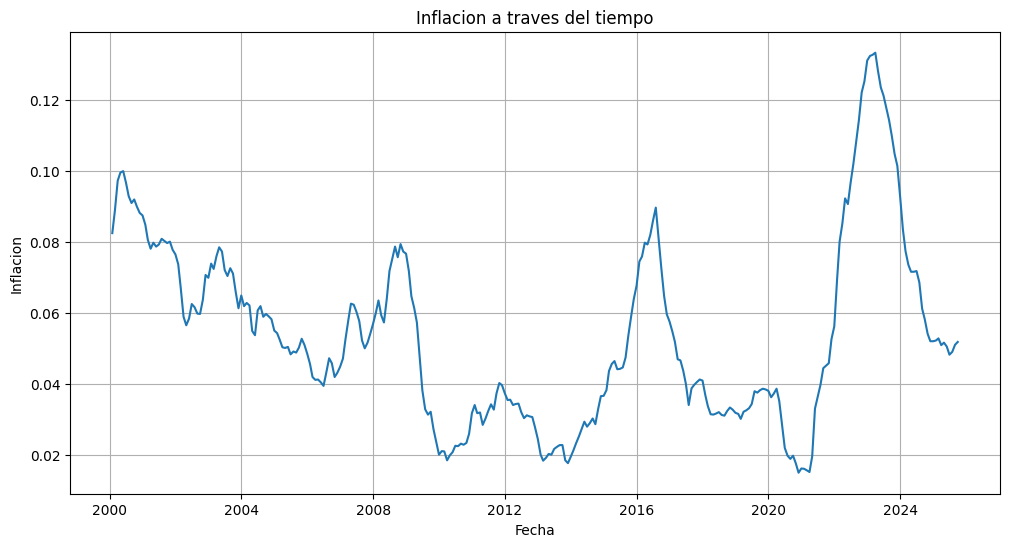

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Inflacion'])
plt.title('Inflacion a traves del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Inflacion')
plt.grid(True)
plt.show()

### Secuencia de ventanas
Para entrenar un modelo recurrente es necesario transformar la serie temporal en un conjunto de secuencias de entrada y salida.

Este proceso se conoce como **sliding window** o ventana deslizante, y consiste en recorrer los datos históricos con una ventana de longitud fija que captura una secuencia de valores pasados (entrada), asociándola con uno o varios valores futuros (salida).

Por ejemplo, si tenemos la siguiente serie temporal:

$$ [x_1,x_2,\dotsb, x_t  ]$$

y tenemos una ventana ```n_steps_in = 3``` para retornar un solo valor ```n_steps_out = 1```. Entonces las muestras de entrenamiento son de la forma:

* Entrada: $[x_1,x_2,x_3]$. Salida: $x_4$
* Entrada: $[x_2,x_3,x_4]$. Salida: $x_5$.
* Entrada: $[x_{i-1},x_i,x_{i+1}]$. Salida: $x_{i+2}$.

In [ ]:
def create_sequences(data, n_steps_in, n_steps_out):
    """
    Crea secuencias de entrada-salida para LSTM usando sliding window
    Argumentos:
    data -- array 1D con los datos de inflación
    n_steps_in -- número de pasos temporales de entrada (ventana)
    n_steps_out -- número de pasos a predecir (tamaño de la salida).

    Retorna:
    X -- array con secuencias de entrada, shape (n_samples, n_steps_in)
    Y -- array con valores objetivo, shape (n_samples, n_steps_out)
    """
    X, Y = [], []
    ### START CODE HERE ###
    # Recorremos la serie aplicando la ventana deslizante
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        # Secuencia de entrada: ventana de n_steps_in valores. X.append(...)
        X.append(data[i:(i + n_steps_in)])
        # Valor objetivo: el siguiente valor después de la ventana. Y.append(...)
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    ### END CODE HERE ###

    return np.array(X), np.array(Y)

In [ ]:
# Tester de la funcion create_sequences
# Fijamos una semilla para los test
np.random.seed(42)
# Generamos 20 datos aleatorios
random_data = np.random.rand(20)

# Imprimimos los datos generados
print("Datos aleatorios generados:")
print(random_data)

# Definimos los parámetros
n_steps_in = [5,3,6,3]
n_steps_out = [2,1,4,3]

# Iteramos sobre los parametros
for n_steps_in_value, n_steps_out_value in zip(n_steps_in, n_steps_out):
  X, Y = create_sequences(random_data, n_steps_in_value, n_steps_out_value)
  # Imprimimos solo el primer caso
  if n_steps_in_value == 5:
    print("\nPrimer secuencia de entrada (X):")
    print(X[0])
    print("\nPrimer secuencia de salida (Y):")
    print(Y[0])
  # Verificamos el número de secuencias esperadas
  expected_num_sequences = len(random_data) - n_steps_in_value - n_steps_out_value + 1
  assert len(X) == expected_num_sequences, f"Expected {expected_num_sequences} sequences, but got {len(X)}"
  assert len(Y) == expected_num_sequences, f"Expected {expected_num_sequences} sequences, but got {len(Y)}"
  # Verificamos el shape de las secuencias
  assert X.shape == (expected_num_sequences, n_steps_in_value), f"Expected X shape {(expected_num_sequences, n_steps_in_value)}, but got {X.shape}"
  assert Y.shape == (expected_num_sequences, n_steps_out_value), f"Expected Y shape {(expected_num_sequences, n_steps_out_value)}, but got {Y.shape}"
  # Verificamos el primer elemento de las secuencias
  assert np.array_equal(X[0], random_data[:n_steps_in_value]), f"First input sequence is incorrect. Expected {random_data[:n_steps_in_value]}, but got {X[0]}"
  assert np.array_equal(Y[0], random_data[n_steps_in_value:n_steps_in_value + n_steps_out_value]), f"First output sequence is incorrect. Expected {random_data[n_steps_in_value:n_steps_in_value + n_steps_out_value]}, but got {Y[0]}"

print('\033[92mTest Aprobado\033[0m')

Datos aleatorios generados:
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914]

Primer secuencia de entrada (X):
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]

Primer secuencia de salida (Y):
[0.15599452 0.05808361]
Test Aprobado


**Datos esperados:**

Primer secuencia de entrada (X):
```
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
```

Primer secuencia de salida (Y):
```
[0.15599452 0.05808361]
```